In [1]:
pwd

'/home/vmu/nu_stats'

In [2]:
%cd examples/bayes_hierarchical_model/

/home/vmu/nu_stats/examples/bayes_hierarchical_model


In [3]:
#import dill

In [4]:
#dill.load_session('notebook_env.db')

In [5]:
#dill.dump_session('notebook_env1203.db')

In [6]:
%load_ext autoreload
%autoreload 2

# SIM

In [7]:
from astropy import units as u
import numpy as np
from cmdstanpy import CmdStanModel
import arviz, corner
from matplotlib import pyplot as plt

In [8]:
import sys
sys.path.append("../../")
from nu_stats.simulation import Simulation
from nu_stats.plotting import unit_vectors_skymap as u_v_s

In [9]:
# Choose simulation parameters
L = 1e48 * (u.erg/u.s)
gamma = 2.2
z = 0.3
F_diff_norm = 1e-15 * 1/(u.GeV * u.cm**2 * u.s)
Emin = 1e5 * u.GeV
Emax = 1e8 * u.GeV
Enorm = 1e5 * u.GeV

In [10]:
sim = Simulation(L, gamma, z, F_diff_norm, Emin, Emax, Enorm,)
sim.run(seed=40)


Simulated 274 events


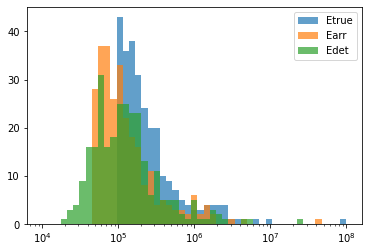

In [11]:
sim.show_spectrum()

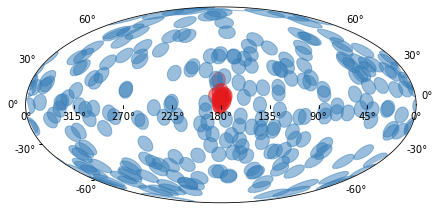

In [38]:
sim.show_skymap()

In [13]:
sim.truth

OrderedDict([('L', 6.2415090744607645e+50),
             ('gamma', 2.2),
             ('F_diff', 8.331240094640407e-07),
             ('f', <Quantity 0.05463271>)])

In [14]:
sim.labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [15]:
# Extract simulated data and get info needed for fit
fit_input = sim.get_data()

In [16]:
#fit_input

# FQTIST FIT

In [17]:
from nu_stats.fqutils import FqStructure

In [18]:
# With energy part
fq = FqStructure(z, Emin, Emax, Esim_gamma = 1.5, n_Esim=100000)

/home/vmu/Envs/exj/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Simulated 100000 events
Marginalized energy likelihood generated.


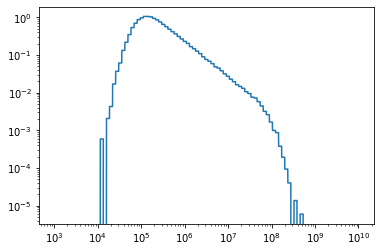

In [19]:
fq.energy_likelihood.show_pdf_at_idx(2)

The log(full fit input likelihood) for a pair n_s, gamma can be evaluated as follows:

In [20]:

n_s_eg = 3
gamma_eg = 2
fq.fit_input = fit_input
fq.log_band_likelihood(3,2)

-191.22783244569877

Above can be evaluated for arrays of different n_s and gamma as follows:

In [21]:
n_ss = np.arange(fit_input['N'])
gammas = np.linspace(1.6,4,100) 
glbl = fq.grid_log_band_likelihood(n_ss, gammas) # *

# result is saved in the fq object as well
assert (glbl == fq.lbl_grid).all() 

n_h_i, g_h_i = fq.argmax_band_likelihood()
# no args: grid kept from *


In [22]:
sum(sim.labels==0)

19

In [23]:
n_ss[n_h_i]

12

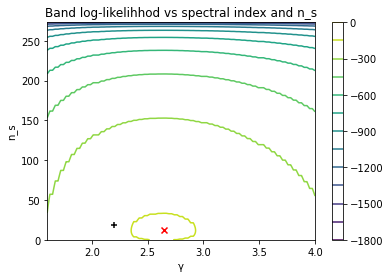

In [24]:
fq.plot_lbl_contour()
plt.scatter(sim.truth['gamma'], sum(sim.labels==0), marker='+', c ='k')
plt.show()


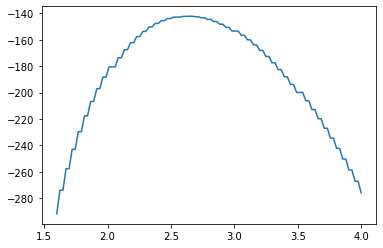

In [25]:
plt.plot(gammas, fq.lbl_grid[15,:]);

The source likelihood for a specific event for different gammas can be evaluated as follows:

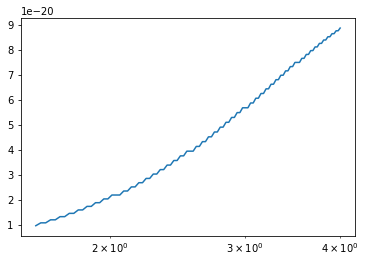

In [26]:
fq.event_source_likelihood_from_index(gammas, 1)
plt.plot(gammas, fq.sl_arr)
plt.xscale('log')
plt.show()

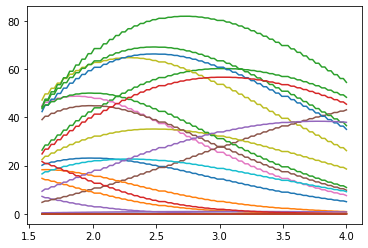

In [27]:
for event_i in range(fit_input['N']):
    plt.plot(gammas,
         fq.event_source_likelihood_from_index(gammas, event_i))
plt.show()

#### FqStructure can also be set to ignore energy part:

In [28]:
fq_noE = FqStructure() # Only spatial

Marginalized energy likelihood taken to be 1.


In [29]:
#fq_noE.log_band_likelihood(fit_input, 39,2)

In [30]:
glbl = fq_noE.grid_log_band_likelihood(np.arange(fit_input['N']),  np.linspace(1.5,4), fit_input=fit_input)

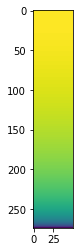

In [31]:
plt.imshow(glbl)

In [32]:
np.arange(fit_input['N']).max()

273

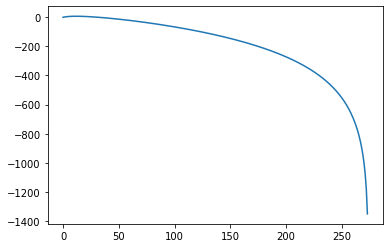

In [33]:
plt.plot(glbl[:,1]);

## Individual associations

In [34]:
bg_sim = Simulation(0*u.erg/u.s, gamma, z, F_diff_norm, Emin, Emax, Enorm, 100000)
bg_sim.run(seed=12345678)
bg_dat = bg_sim.get_data()

Simulated 100000 events


In [35]:
bg_sim.truth

OrderedDict([('L', 0.0),
             ('gamma', 2.2),
             ('F_diff', 8.331240094640407e-07),
             ('f', <Quantity 0.>)])

In [36]:
## get p values
sim_TS, bg_TS, sim_p = fq.event_statistics(fit_input, bg_dat, 2)
## set label 0 for p<.01 and 1 for p>=.01
labels = (sim_p >=.01).astype(int)

/home/vmu/nu_stats/nu_stats/fqutils.py:241: RuntimeWarning: invalid value encountered in double_scalars
  TS[j] = 2*np.log(S / self.bg_likelihood(E_r[j], gamma))


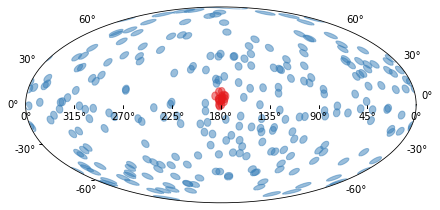

In [37]:
u_v_s(fit_input['det_dir'], labels);

In [40]:
np.mean(labels == sim.labels)

0.9963503649635036

In [44]:
print(f'Source event fraction\nfit: {np.mean(1-labels)}\n\
true: {np.mean(1-sim.labels)}\n\n\
False source events: {np.inner(1-sim.labels, labels)}\n\
False bg events: {np.inner(1-labels, sim.labels)}')

Source event fraction
fit: 0.06569343065693431
true: 0.06934306569343066

False source events: 1
False bg events: 0


In [45]:
bg_TS.sort()

In [46]:
frac = lambda x: np.mean(bg_TS > x)
y = np.array([frac(elem) for elem in bg_TS])

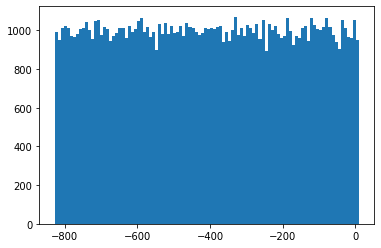

In [47]:
plt.hist(bg_TS,bins=100);

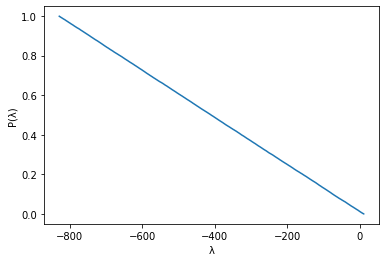

In [48]:

plt.step(bg_TS, y);
plt.xlabel('λ');
plt.ylabel('P(λ)');
#plt.yscale('log');

# BHM

In [49]:
stan_model = CmdStanModel(stan_file="stan/toy_bhm.stan")
fit = stan_model.sample(data=fit_input, iter_sampling=1000, chains=4, seed=42)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/vmu/nu_stats/examples/bayes_hierarchical_model/stan/toy_bhm
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4


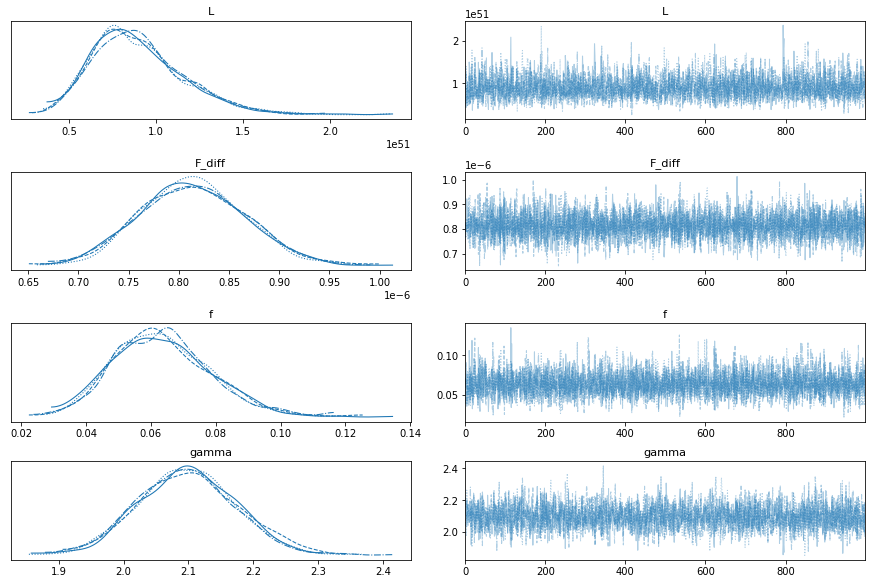

In [50]:
# Trace plot
var_names = ["L", "F_diff", "f", "gamma"]
arviz.plot_trace(fit, var_names=var_names);


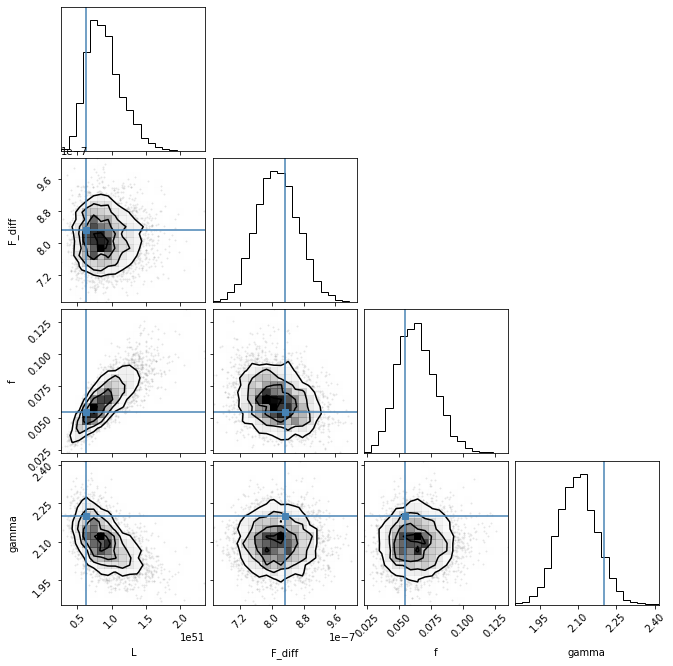

In [51]:
# Corner plot, comparing with truth form sim
variables = fit.stan_variables()
samples = np.column_stack([variables[key] for key in var_names])
truths_list = [sim.truth[key] for key in var_names]

corner.corner(samples, labels=var_names, truths=truths_list);

In [52]:
fit.diagnose()


INFO:cmdstanpy:Processing csv files: /tmp/tmpiidmlogh/toy_bhm-202103152235-1-774q80f_.csv, /tmp/tmpiidmlogh/toy_bhm-202103152235-2-9a6hthtw.csv, /tmp/tmpiidmlogh/toy_bhm-202103152235-3-w4kcuir7.csv, /tmp/tmpiidmlogh/toy_bhm-202103152235-4-68w6ukim.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


'Processing csv files: /tmp/tmpiidmlogh/toy_bhm-202103152235-1-774q80f_.csv, /tmp/tmpiidmlogh/toy_bhm-202103152235-2-9a6hthtw.csv, /tmp/tmpiidmlogh/toy_bhm-202103152235-3-w4kcuir7.csv, /tmp/tmpiidmlogh/toy_bhm-202103152235-4-68w6ukim.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.'

In [53]:
fit.summary()

Mean          MCSE        StdDev            5%  \
name                                                                
lp__      -8.700000e+03  4.300000e-01  1.400000e+01 -8.700000e+03   
gamma      2.100000e+00  1.300000e-03  7.500000e-02  2.000000e+00   
L          9.000000e+50  4.000000e+48  2.600000e+50  5.300000e+50   
F_diff     8.100000e-07  6.300000e-10  5.200000e-08  7.300000e-07   
Etrue[1]   1.506010e+05  6.580000e+02  5.065300e+04  1.029130e+05   
...                 ...           ...           ...           ...   
Earr[270]  8.252900e+04  4.190000e+02  3.220700e+04  5.172400e+04   
Earr[271]  1.512870e+05  1.035000e+03  8.136800e+04  6.172000e+04   
Earr[272]  7.828200e+04  3.840000e+02  2.914400e+04  5.138700e+04   
Earr[273]  6.578600e+04  2.260000e+02  1.712600e+04  5.069000e+04   
Earr[274]  1.942530e+05  1.330000e+03  1.017240e+05  8.039200e+04   

                    50%           95%   N_Eff  N_Eff/s  R_hat  
name                                                           
lp__      -8.700000e+03 -8.700000e+03  1000.0     21.0    1.0  
gamma      2.100000e+00  2.200000e+00  3400.0     70.0    1.0  
L          8.600000e+50  1.400000e+51  4300.0     88.0    1.0  
F_diff     8.100000e-07  9.000000e-07  6800.0    140.0    1.0  
Etrue[1]   1.358250e+05  2.481360e+05  5921.0    122.0    1.0  
...                 ...           ...     ...      ...    ...  
Earr[270]  7.348400e+04  1.432140e+05  5919.0    122.0    1.0  
Earr[271]  1.309370e+05  3.068110e+05  6186.0    127.0    1.0  
Earr[272]  6.960200e+04  1.370430e+05  5745.0    118.0    1.0  
Earr[273]  6.045700e+04  9.849100e+04  5765.0    119.0    1.0  
Earr[274]  1.697970e+05  3.876200e+05  5851.0    120.0    1.0  

[1109 rows x 9 columns]

In [54]:
fit.stan_variable('log_prob').shape

(4000, 274, 2)

## Individual associations


In [55]:
import nu_stats.bhmutils as bhm

In [56]:
association = bhm.classify_events(fit_input, fit)

In [57]:
labels_b = (association[:,0] <.01).astype(int)

In [58]:
labels_b

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [59]:
labels_b.mean()

0.9197080291970803

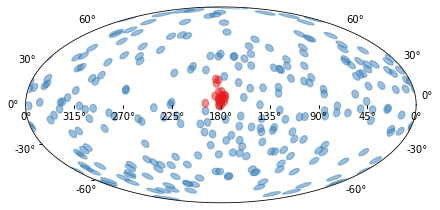

In [60]:
u_v_s(fit_input['det_dir'], labels_b);

In [61]:
np.mean(labels_b == sim.labels)

0.9890510948905109

In [63]:
print(f'Source event fraction\nfit: {np.mean(1-labels_b)}\n\
true: {np.mean(1-sim.labels)}\n\n\
False source events: {np.inner(sim.labels, 1-labels_b)}\n\
False bg events: {np.inner(labels_b, 1-sim.labels)}')

Source event fraction
fit: 0.08029197080291971
true: 0.06934306569343066

False source events: 3
False bg events: 0
